# Literature data reprocessing and calculations
This notebook reprocesses the calculations from the Rapid Response to match exactly calculation methods from PrePost Caldera project ( SO2 mol%, T, XH2O and MC simulations).
The original data contains Raman and SEM-EDS, no EBSD.
The steps are as follows:
- 1. Import dependencies and install packages
- 2. Import dataset and clear up columns not needed
- 3. calculate SO2 mol% from Raman ratios
- 4. Calculate T from olivine only thermometer using SEM-EDS on host olivines
- 5. Calculate XH2O iteratively 
- 6. Calculate final P and D and uncertainty via Monte Carlo simulations
- 7. Exports final dataset to excel for plotting in a separate notebook

## 1. Import packages and setup folders and paths

### Install packages if not installed

In [1]:
#%pip install --upgrade DiadFit
#%pip install Thermobar

### Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf
import os
import pickle

### Setup folders and data paths

In [3]:
# This is to make sure the code runs regardless of operating system
if os.name=='posix':
    slash='/'
else:
    slash='\\'

# Set master folder
MasterFolder=os.path.dirname(os.path.dirname(os.getcwd()))

# #Folder to save figures

figpath=MasterFolder +slash+"Data_processing_notebooks"+slash+"Data_reprocessing_Literature"+slash+'Processing Figs'
if not os.path.exists(figpath):
    os.mkdir(figpath)

# Create folder to save full datasets

compilation_folder=MasterFolder +slash+"Data_processing_notebooks"+slash+"Data_reprocessing_Literature"+slash+'Notebook_Compiled_data'
if not os.path.exists(compilation_folder):
    os.mkdir(compilation_folder)

## 2. Import dataset and clean up columns not needed

### Import JPET rapid response Sept 2023 data


In [4]:
K23=pd.read_excel(MasterFolder +slash+"Data_processing_notebooks"+slash+'Data_reprocessing_Literature'+slash+'Data_Lit'+slash+'JPETegae119_supplement_rapidresponse'+slash+'S2_SI_Dataset_final.xlsx',skiprows=[0,2])

K23 =K23.loc[:, ~K23.columns.str.contains('Unnamed')].copy()
K23['Recalculations for Pre-Post Caldera paper >']=np.nan
K23['Sample']='K23'
K23.columns.tolist()
K23.head()

,Column headers,py_index,Crystal Name,FI Name,Reported density mean of reps?,Density g/cm3,"σ Density g/cm3 (as plotted, from DiadFit for individual, Std dev for averaged FI)",STDofreps_Density g/cm3,σ Density g/cm3 (DiadFit),σ Density g/cm3 (from Ne+peakfit),...,XH2O_iteration5_min,P_mix_min/P_pureCO2,P_kbar_mixCO2_DZ06_Hloss_iteration5_av,XH2O_iteration5_av,P_mix_av/P_pureCO2,P_kbar_mixCO2_DZ06_Hloss_iteration5_max,XH2O_iteration5_max,P_mix_max/P_pureCO2,Recalculations for Pre-Post Caldera paper >,Sample
0,NaN,0,K23_101,K23_101_FIC,No,0.085665,0.007736,NaN,0.007736,0.006738,...,0.053569,1.053743,0.300597,0.107846,1.116509,0.318960,0.160045,1.184715,NaN,K23
1,NaN,1,K23_101,K23_101_FID,No,0.100137,0.005037,NaN,0.005037,0.003301,...,0.046297,1.045784,0.349657,0.093476,1.099175,0.367821,0.138888,1.156277,NaN,K23
2,NaN,2,K23_102,K23_102_FIA,No,0.112454,0.004482,NaN,0.004482,0.002350,...,0.041096,1.040210,0.391640,0.083402,1.087447,0.409664,0.124194,1.137491,NaN,K23
3,NaN,3,K23_10,K23_10_FIA,No,0.131039,0.004066,NaN,0.004066,0.001310,...,0.035974,1.035015,0.442067,0.073697,1.076713,0.460070,0.110177,1.120562,NaN,K23
4,NaN,4,K23_1,K23_1_FIA,Yes,0.142919,0.002579,0.002579,0.003950,0.000744,...,0.031950,1.030739,0.492191,0.066293,1.068475,0.510410,0.099630,1.108026,NaN,K23


### Import the GPL LERZ2018 Data

In [5]:
skip_rows = list(range(0, 8)) + list(range(111, 200))
LERZ2018=pd.read_excel(MasterFolder +slash+"Data_processing_notebooks"+slash+'Data_reprocessing_Literature'+slash+'Data_Lit'+slash+'GPL2404_TS-1-TS-7.xlsx',sheet_name='Table S-1 Kīlauea FI',skiprows=skip_rows)

LERZ2018['Recalculations for Pre-Post Caldera paper >']=np.nan
LERZ2018['Eruption']='LERZ2018'
LERZ2018 =LERZ2018.loc[:, ~LERZ2018.columns.str.contains('Unnamed')]
LERZ2018.head()

,Py_index,Event Description,"Event ID (LL8 - July, LL7-Aug, LL4-May)",Host crystal ID,Fluid inclusion ID,Raman Data >,Fermi Diad separation ΔCO2 (cm-1),Corrected ΔCO2 (cm-1),Corrected ΔCO2 1σ (cm-1),CO2 density (g/cm3),...,"Magmasat Saturation Pressure (Glass only, PEC corrected)",Magmasat Saturation Pressure (mean bubble CO2 from EOS+Glass CO2; PEC corrected),Magmasat Saturation Pressure (max bubble CO2 from EOS+Glass CO2; PEC corrected),Magmasat Saturation Pressure (min bubble CO2 from EOS+Glass CO2; PEC corrected),"Shishkina Saturation pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)","Shishkina Saturation pressure Min CO2 (glass+bubble, PEC corr,-1 sigma splitting -1 sigmabubble vol)",Shishkina Saturation pressure (Glass only CO2),Shishkina Saturation pressure (EOS method - glass+ reconstructed bubble),Recalculations for Pre-Post Caldera paper >,Eruption
0,0,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#1,ν1 refers to the low wavenumber band of the fe...,103.416763,103.186144,0.006461,0.176605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LERZ2018
1,1,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#2,NaN,103.431244,103.195894,0.007137,0.180578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LERZ2018
2,2,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-MI#1,NaN,103.429713,103.196578,0.010404,0.180858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LERZ2018
3,3,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-#2,NaN,103.379425,103.122405,0.001766,0.147317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LERZ2018
4,7,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-MI#5,NaN,103.170121,102.953345,0.007431,0.080378,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LERZ2018


## 3. Calculate SO2 mol % from Raman

### Calculate SO2 mol% for K23

In [6]:
K23['SO2 mol%_recalculated']=pf.calculate_mole_fraction_2comp(peak_area_a=K23['Peak_Area_SO2'], peak_area_b=K23['Diad1_Voigt_Area']+K23['Diad2_Voigt_Area'],
                                  cross_section_a=5.3, cross_section_b=1.4+0.89, instrument_eff_a=1, instrument_eff_b=1)['% A']



#K23['Fo']=(K23['MgO']/40.3044)/((K23['MgO']/40.3044)+(K23['FeOt']/71.844))

### Calculate SO2 mol% for LERZ2018

In [7]:
LERZ2018['SO2 mol%_recalculated']=pf.calculate_mole_fraction_2comp(peak_area_a=LERZ2018['SO2_Area'], peak_area_b=LERZ2018['ν1_Voigt_Area']+LERZ2018['2ν2_Voigt_Area'],
                                  cross_section_a=5.3, cross_section_b=1.4+0.89, instrument_eff_a=1, instrument_eff_b=1)['% A']

## 4. Calculate the Temperature from olivine only thermometer
- This uses the T vs Fo relationship from DeVitre and Wieser (2024) GPL for Kilauea

### A. Load the Temp vs Fo correction relationship for Kilauea

In [8]:
with open(MasterFolder+slash+'Data_processing_notebooks'+slash+'T and XH2O pickles'+slash+'TempFoModel.pkl', 'rb') as f:
    Pf_TempFo = pickle.load(f)

### B. Calculate Temperature from Fo and plot the distribution
- When no EDS data is available we use the mean T from the dataset (once I have other samples I can maybe do a mean per sample)
- We establish the error on T (+- 50K for now)

#### Calculate T for K23

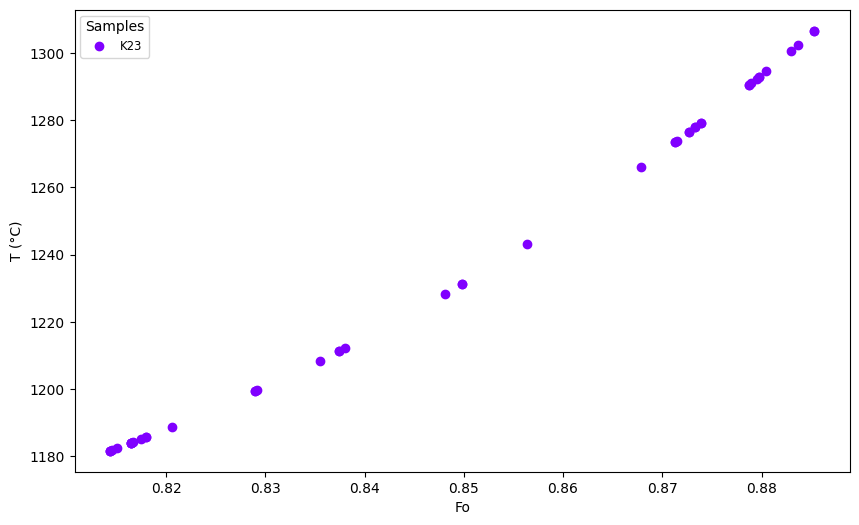

In [9]:
K23['Temp_from_Fo_all']=Pf_TempFo(K23['Fo'])
MeanT=np.nanmean(K23['Temp_from_Fo_all'])
K23['Temp_from_Fo_all'] = K23['Temp_from_Fo_all'].fillna(MeanT)

# Create Temp error column, we use 50K +- for now.
K23['Temp_error'] = np.where(K23['Temp_from_Fo_all'] == MeanT, 50, 50)

####### Now let's plot the Temp vs Fo to visualize the distribution
unique_samples = K23['Sample'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_samples)))
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'H', '+', 'x', 'X']  # List of markers

if len(unique_samples) > len(markers):
    print("Warning: More samples than available marker types; some markers will repeat.")

plt.figure(figsize=(10, 6))

for sample, color, marker in zip(unique_samples, colors, markers * (len(unique_samples) // len(markers) + 1)):
    sample_data = K23[K23['Sample'] == sample]
    plt.plot(
        sample_data['Fo'], 
        sample_data['Temp_from_Fo_all'], 
        linestyle='none', 
        marker=marker, 
        label=sample, 
        color=color
    )

plt.xlabel('Fo')
plt.ylabel('T (°C)')

plt.legend(title="Samples", loc="best", fontsize='small')
plt.savefig(figpath+slash+'Temp_vs_Fo_plot_K23.pdf')
plt.show()

#### Calculate T for LERZ2018

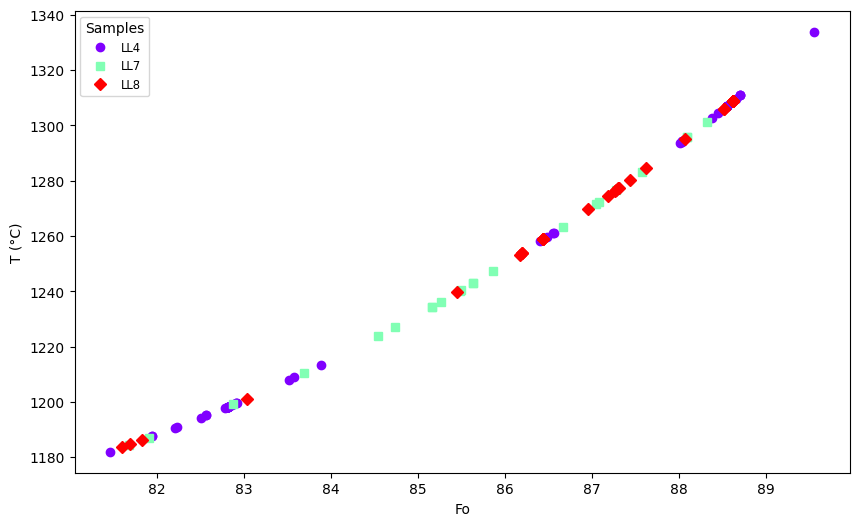

In [10]:
LERZ2018['Temp_from_Fo_all']=Pf_TempFo(LERZ2018['Corrected Fo content (molar %)_Cambridge']/100)
MeanT=np.nanmean(LERZ2018['Temp_from_Fo_all'])
LERZ2018['Temp_from_Fo_all'] = LERZ2018['Temp_from_Fo_all'].fillna(MeanT)

# Create Temp error column, we use 50K +- for now.
LERZ2018['Temp_error'] = np.where(LERZ2018['Temp_from_Fo_all'] == MeanT, 50, 50)

####### Now let's plot the Temp vs Fo to visualize the distribution
unique_samples = LERZ2018['Event ID (LL8 - July, LL7-Aug, LL4-May)'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_samples)))
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'H', '+', 'x', 'X']  # List of markers

if len(unique_samples) > len(markers):
    print("Warning: More samples than available marker types; some markers will repeat.")

plt.figure(figsize=(10, 6))

for sample, color, marker in zip(unique_samples, colors, markers * (len(unique_samples) // len(markers) + 1)):
    sample_data = LERZ2018[LERZ2018[ 'Event ID (LL8 - July, LL7-Aug, LL4-May)'] == sample]
    plt.plot(
        sample_data['Corrected Fo content (molar %)_Cambridge'], 
        sample_data['Temp_from_Fo_all'], 
        linestyle='none', 
        marker=marker, 
        label=sample, 
        color=color
    )

plt.xlabel('Fo')
plt.ylabel('T (°C)')

plt.legend(title="Samples", loc="best", fontsize='small')
plt.savefig(figpath+slash+'Temp_vs_Fo_plot_LERZ2018.pdf')
plt.show()

## 5. Calculate the XH2O in the fluid inclusions
- This uses the relationships from DeVitre and Wieser (2024) GPL
- First we import the pickles (min, average, max - see paper for details)
- Then we calculate a first approximation of pressure using pure CO2 EOS, and calculate a first approximation of XH2O from this pressure
- After that we recalculate the pressure using mixed CO2-H2O EOS from Duan and Zhang 2006
- We recalculate XH2O from this new pressure
- We recalculate pressure and XH2O one more time to ensure it has not varied

### A. First, import the pickles (polynomial relationships)

In [11]:
LERZ2018.columns.to_list()

['Py_index',
 'Event Description',
 'Event ID (LL8 - July, LL7-Aug, LL4-May)',
 'Host crystal ID',
 'Fluid inclusion ID',
 'Raman Data >',
 'Fermi Diad separation ΔCO2 (cm-1)',
 'Corrected ΔCO2 (cm-1)',
 'Corrected ΔCO2 1σ (cm-1)',
 'CO2 density (g/cm3)',
 'CO2 density 1σ (g/cm3)',
 'Mean of repeated Analyses (Yes/No)',
 'Repeats done all in same day (Yes/No)',
 'Corrected ΔCO2 standard deviation of repeats (cm-1)',
 'CO2 density standard deviation of repeats (g/cm3)',
 'Notes',
 'ν1_Combofit_position (cm-1)',
 'ν1_Combofit_position_error (cm-1)',
 'ν1_Combofit_height (a.u.)',
 'ν1_Voigt_position (cm-1)',
 'ν1_Voigt_Area',
 'ν1_Voigt_Sigma',
 'ν1_Residual',
 'ν1_Prop_Lor',
 'ν1_fwhm',
 'ν1_yuan_maya_criterion',
 '2ν2_Combofit_position (cm-1)',
 '2ν2_Combofit_position_error (cm-1)',
 '2ν2_Combofit_height (a.u.)',
 '2ν2_Voigt_position (cm-1)',
 '2ν2_Voigt_Area',
 '2ν2_Voigt_Sigma',
 '2ν2_Residual',
 '2ν2_Prop_Lor',
 '2ν2_fwhm',
 '2ν2_yuan_maya_criterion',
 'HB1_position (cm-1)',
 'HB1_Ar

In [12]:
pf_files = ["PXH2O_min.pkl", "PXH2O_max.pkl", "PXH2O_av.pkl"]
Pf_functions = {}

for file_name, label in zip(pf_files, ["Pf_min", "Pf_max", "Pf_av"]):
    with open(os.path.join(MasterFolder+slash+'Data_processing_notebooks', "T and XH2O pickles", file_name), 'rb') as f:
        Pf_functions[label] = pickle.load(f)

Pf_min = Pf_functions["Pf_min"]
Pf_max = Pf_functions["Pf_max"]
Pf_av = Pf_functions["Pf_av"]

# And its defined as XH2O_av=1-Pf_med(P_SW96['P_MPa'])

### B. Calculate the first approximation XH2O

#### First, calculate approximated pressure with pure CO2 EOS

In [13]:
K23['P_kbar_pureCO2_firstapprox'] =pf.calculate_P_for_rho_T(CO2_dens_gcm3=K23['Density g/cm3'],
                                                                        T_K=K23['Temp_from_Fo_all'] + 273.15,
                                                                        EOS='SW96')['P_kbar']

LERZ2018['P_kbar_pureCO2_firstapprox'] =pf.calculate_P_for_rho_T(CO2_dens_gcm3=LERZ2018['CO2 density (g/cm3)'],
                                                                        T_K=LERZ2018['Temp_from_Fo_all'] + 273.15,
                                                                        EOS='SW96')['P_kbar']

display(K23.head())
display(LERZ2018.head())

,Column headers,py_index,Crystal Name,FI Name,Reported density mean of reps?,Density g/cm3,"σ Density g/cm3 (as plotted, from DiadFit for individual, Std dev for averaged FI)",STDofreps_Density g/cm3,σ Density g/cm3 (DiadFit),σ Density g/cm3 (from Ne+peakfit),...,P_mix_av/P_pureCO2,P_kbar_mixCO2_DZ06_Hloss_iteration5_max,XH2O_iteration5_max,P_mix_max/P_pureCO2,Recalculations for Pre-Post Caldera paper >,Sample,SO2 mol%_recalculated,Temp_from_Fo_all,Temp_error,P_kbar_pureCO2_firstapprox
0,NaN,0,K23_101,K23_101_FIC,No,0.085665,0.007736,NaN,0.007736,0.006738,...,1.116509,0.318960,0.160045,1.184715,NaN,K23,-0.309044,1292.655593,50,0.269230
1,NaN,1,K23_101,K23_101_FID,No,0.100137,0.005037,NaN,0.005037,0.003301,...,1.099175,0.367821,0.138888,1.156277,NaN,K23,1.699992,1292.655593,50,0.318108
2,NaN,2,K23_102,K23_102_FIA,No,0.112454,0.004482,NaN,0.004482,0.002350,...,1.087447,0.409664,0.124194,1.137491,NaN,K23,NaN,1290.946549,50,0.360147
3,NaN,3,K23_10,K23_10_FIA,No,0.131039,0.004066,NaN,0.004066,0.001310,...,1.076713,0.460070,0.110177,1.120562,NaN,K23,4.781801,1238.332018,50,0.410571
4,NaN,4,K23_1,K23_1_FIA,Yes,0.142919,0.002579,0.002579,0.003950,0.000744,...,1.068475,0.510410,0.099630,1.108026,NaN,K23,NaN,1265.953462,50,0.460648


,Py_index,Event Description,"Event ID (LL8 - July, LL7-Aug, LL4-May)",Host crystal ID,Fluid inclusion ID,Raman Data >,Fermi Diad separation ΔCO2 (cm-1),Corrected ΔCO2 (cm-1),Corrected ΔCO2 1σ (cm-1),CO2 density (g/cm3),...,"Shishkina Saturation pressure Max CO2 (glass+bubble, PEC corr,+1 sigma splitting +1 sigmabubble vol)","Shishkina Saturation pressure Min CO2 (glass+bubble, PEC corr,-1 sigma splitting -1 sigmabubble vol)",Shishkina Saturation pressure (Glass only CO2),Shishkina Saturation pressure (EOS method - glass+ reconstructed bubble),Recalculations for Pre-Post Caldera paper >,Eruption,SO2 mol%_recalculated,Temp_from_Fo_all,Temp_error,P_kbar_pureCO2_firstapprox
0,0,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#1,ν1 refers to the low wavenumber band of the fe...,103.416763,103.186144,0.006461,0.176605,...,NaN,NaN,NaN,NaN,NaN,LERZ2018,4.088172,1259.723187,50,0.582127
1,1,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#2,NaN,103.431244,103.195894,0.007137,0.180578,...,NaN,NaN,NaN,NaN,NaN,LERZ2018,2.406601,1258.065163,50,0.596455
2,2,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-MI#1,NaN,103.429713,103.196578,0.010404,0.180858,...,NaN,NaN,NaN,NaN,NaN,LERZ2018,6.492751,1261.215617,50,0.598838
3,3,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-#2,NaN,103.379425,103.122405,0.001766,0.147317,...,NaN,NaN,NaN,NaN,NaN,LERZ2018,NaN,1213.468027,50,0.459202
4,7,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-MI#5,NaN,103.170121,102.953345,0.007431,0.080378,...,NaN,NaN,NaN,NaN,NaN,LERZ2018,NaN,1261.058075,50,0.246376


#### Next, we calculate the XH2O first approximation

In [14]:
# Create function to calculate XH2O from pickles that were loaded,
# If XH2O is negative we assign 0 to it
def calculate_XH2O(P_kbar, Pf_func):
    XH2O = 1 - Pf_func(P_kbar * 100)
    XH2O[XH2O < 0] = 0
    return XH2O

K23['XH2O_av_firstapprox'] = calculate_XH2O(K23['P_kbar_pureCO2_firstapprox'], Pf_av)
K23['XH2O_min_firstapprox'] = calculate_XH2O(K23['P_kbar_pureCO2_firstapprox'], Pf_min)
K23['XH2O_max_firstapprox'] = calculate_XH2O(K23['P_kbar_pureCO2_firstapprox'], Pf_max)

LERZ2018['XH2O_av_firstapprox'] = calculate_XH2O(LERZ2018['P_kbar_pureCO2_firstapprox'], Pf_av)
LERZ2018['XH2O_min_firstapprox'] = calculate_XH2O(LERZ2018['P_kbar_pureCO2_firstapprox'], Pf_min)
LERZ2018['XH2O_max_firstapprox'] = calculate_XH2O(LERZ2018['P_kbar_pureCO2_firstapprox'], Pf_max)

### C. Now, we iterate calculations using mixed H2O-CO2 EOS of Duan and Zhang
- We do 3 iterations: this means P, XH2O; P2, XH2O2;P3, XH2O final

#### First, let's do K23

,Column headers,py_index,Crystal Name,FI Name,Reported density mean of reps?,Density g/cm3,"σ Density g/cm3 (as plotted, from DiadFit for individual, Std dev for averaged FI)",STDofreps_Density g/cm3,σ Density g/cm3 (DiadFit),σ Density g/cm3 (from Ne+peakfit),...,P_kbar_mixCO2_DZ06_no_Hloss_max_iteration2,XH2O_av_iteration2,XH2O_min_iteration2,XH2O_max_iteration2,P_kbar_mixCO2_DZ06_no_Hloss_av_iteration3,P_kbar_mixCO2_DZ06_no_Hloss_min_iteration3,P_kbar_mixCO2_DZ06_no_Hloss_max_iteration3,XH2O_av_iteration3_final,XH2O_min_iteration3_final,XH2O_max_iteration3_final
0,NaN,0,K23_101,K23_101_FIC,No,0.085665,0.007736,NaN,0.007736,0.006738,...,0.315446,0.108354,0.053667,0.161712,0.299401,0.283126,0.317289,0.108233,0.053662,0.160818
1,NaN,1,K23_101,K23_101_FID,No,0.100137,0.005037,NaN,0.005037,0.003301,...,0.364269,0.093936,0.046393,0.140256,0.348230,0.331990,0.365749,0.093852,0.046389,0.139676
2,NaN,2,K23_102,K23_102_FIA,No,0.112454,0.004482,NaN,0.004482,0.002350,...,0.406088,0.083813,0.041187,0.125326,0.390018,0.373856,0.407247,0.083756,0.041184,0.124954
3,NaN,3,K23_10,K23_10_FIA,No,0.131039,0.004066,NaN,0.004066,0.001310,...,0.456324,0.074056,0.036058,0.111089,0.440142,0.424042,0.457133,0.074023,0.036056,0.110889
4,NaN,4,K23_1,K23_1_FIA,Yes,0.142919,0.002579,0.002579,0.003950,0.000744,...,0.506552,0.066586,0.032022,0.100329,0.490051,0.473817,0.507087,0.066568,0.032021,0.100231


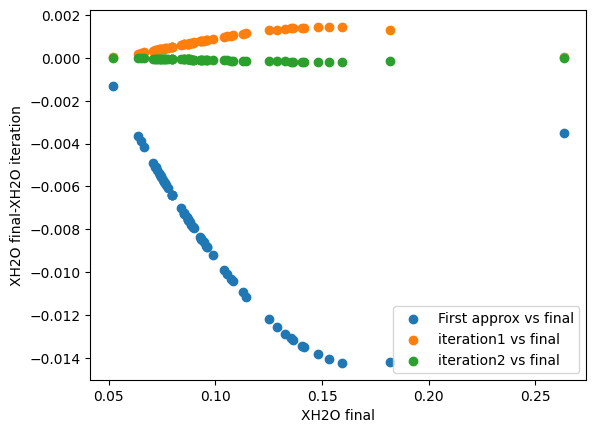

In [15]:
# First we make a function to calculate iterations of P using Duan and Zhang EOS
def calculate_entrapment_pressure(df, XH2O_col):
    return pf.calculate_entrapment_P_XH2O(
        XH2O=df[XH2O_col],
        CO2_dens_gcm3=df['Density g/cm3'],
        T_K=df['Temp_from_Fo_all'] + 273.15,
        T_K_ambient=37 + 273.15,
        fast_calcs=False,
        Hloss=True
    )['P_kbar_mixCO2_DZ06_no_Hloss']

# Then we iterate 3 times to get the final XH2O
for i in range(1, 4):
    if i == 1:
        suffix = '_firstapprox'
    else:
        suffix = f'_iteration{i - 1}'

    # Calculate pressures
    K23[f'P_kbar_mixCO2_DZ06_no_Hloss_av_iteration{i}'] = calculate_entrapment_pressure(K23, f'XH2O_av{suffix}')
    K23[f'P_kbar_mixCO2_DZ06_no_Hloss_min_iteration{i}'] = calculate_entrapment_pressure(K23, f'XH2O_min{suffix}')
    K23[f'P_kbar_mixCO2_DZ06_no_Hloss_max_iteration{i}'] = calculate_entrapment_pressure(K23, f'XH2O_max{suffix}')

    # Calculate XH2O
    K23[f'XH2O_av_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(K23[f'P_kbar_mixCO2_DZ06_no_Hloss_av_iteration{i}'], Pf_av)
    K23[f'XH2O_min_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(K23[f'P_kbar_mixCO2_DZ06_no_Hloss_min_iteration{i}'], Pf_min)
    K23[f'XH2O_max_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(K23[f'P_kbar_mixCO2_DZ06_no_Hloss_max_iteration{i}'], Pf_max)


plt.scatter(K23['XH2O_av_iteration3_final'],K23['XH2O_av_iteration3_final']-K23['XH2O_av_firstapprox'],label='First approx vs final')
plt.scatter(K23['XH2O_av_iteration3_final'],K23['XH2O_av_iteration3_final']-K23['XH2O_av_iteration1'],label='iteration1 vs final')
plt.scatter(K23['XH2O_av_iteration3_final'],K23['XH2O_av_iteration3_final']-K23['XH2O_av_iteration2'],label='iteration2 vs final')
plt.xlabel("XH2O final")
plt.ylabel("XH2O final-XH2O iteration")
plt.legend()
plt.savefig(figpath+slash+'XH2O_iteration_K23.pdf')

K23.head()

#### Next, Let's do LERZ 2018

,Py_index,Event Description,"Event ID (LL8 - July, LL7-Aug, LL4-May)",Host crystal ID,Fluid inclusion ID,Raman Data >,Fermi Diad separation ΔCO2 (cm-1),Corrected ΔCO2 (cm-1),Corrected ΔCO2 1σ (cm-1),CO2 density (g/cm3),...,P_kbar_mixCO2_DZ06_no_Hloss_max_iteration2,XH2O_av_iteration2,XH2O_min_iteration2,XH2O_max_iteration2,P_kbar_mixCO2_DZ06_no_Hloss_av_iteration3,P_kbar_mixCO2_DZ06_no_Hloss_min_iteration3,P_kbar_mixCO2_DZ06_no_Hloss_max_iteration3,XH2O_av_iteration3_final,XH2O_min_iteration3_final,XH2O_max_iteration3_final
0,0,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#1,ν1 refers to the low wavenumber band of the fe...,103.416763,103.186144,0.006461,0.176605,...,0.630592,0.055468,0.025619,0.084859,0.612461,0.595016,0.630743,0.055466,0.025618,0.084847
1,1,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#2,NaN,103.431244,103.195894,0.007137,0.180578,...,0.645442,0.054645,0.025107,0.083762,0.627037,0.609360,0.645571,0.054643,0.025107,0.083753
2,2,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-MI#1,NaN,103.429713,103.196578,0.010404,0.180858,...,0.647914,0.054516,0.025026,0.083590,0.629460,0.611740,0.648040,0.054514,0.025026,0.083582
3,3,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-#2,NaN,103.379425,103.122405,0.001766,0.147317,...,0.505081,0.066771,0.032121,0.100600,0.488630,0.472438,0.505619,0.066753,0.032120,0.100501
4,7,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-MI#5,NaN,103.170121,102.953345,0.007431,0.080378,...,0.292426,0.116203,0.057567,0.173480,0.276393,0.260178,0.294407,0.116065,0.057561,0.172423


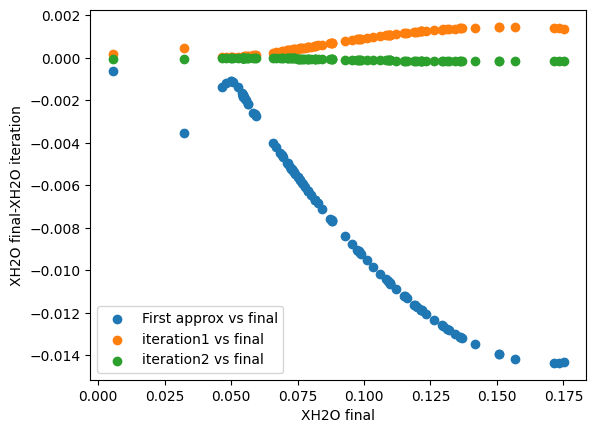

In [16]:
# First we make a function to calculate iterations of P using Duan and Zhang EOS
def calculate_entrapment_pressure(df, XH2O_col):
    return pf.calculate_entrapment_P_XH2O(
        XH2O=df[XH2O_col],
        CO2_dens_gcm3=df['CO2 density (g/cm3)'],
        T_K=df['Temp_from_Fo_all'] + 273.15,
        T_K_ambient=37 + 273.15,
        fast_calcs=False,
        Hloss=True
    )['P_kbar_mixCO2_DZ06_no_Hloss']

# Then we iterate 3 times to get the final XH2O
for i in range(1, 4):
    if i == 1:
        suffix = '_firstapprox'
    else:
        suffix = f'_iteration{i - 1}'

    # Calculate pressures
    LERZ2018[f'P_kbar_mixCO2_DZ06_no_Hloss_av_iteration{i}'] = calculate_entrapment_pressure(LERZ2018, f'XH2O_av{suffix}')
    LERZ2018[f'P_kbar_mixCO2_DZ06_no_Hloss_min_iteration{i}'] = calculate_entrapment_pressure(LERZ2018, f'XH2O_min{suffix}')
    LERZ2018[f'P_kbar_mixCO2_DZ06_no_Hloss_max_iteration{i}'] = calculate_entrapment_pressure(LERZ2018, f'XH2O_max{suffix}')

    # Calculate XH2O
    LERZ2018[f'XH2O_av_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(LERZ2018[f'P_kbar_mixCO2_DZ06_no_Hloss_av_iteration{i}'], Pf_av)
    LERZ2018[f'XH2O_min_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(LERZ2018[f'P_kbar_mixCO2_DZ06_no_Hloss_min_iteration{i}'], Pf_min)
    LERZ2018[f'XH2O_max_iteration{i}{"" if i < 3 else "_final"}'] = calculate_XH2O(LERZ2018[f'P_kbar_mixCO2_DZ06_no_Hloss_max_iteration{i}'], Pf_max)


plt.scatter(LERZ2018['XH2O_av_iteration3_final'],LERZ2018['XH2O_av_iteration3_final']-LERZ2018['XH2O_av_firstapprox'],label='First approx vs final')
plt.scatter(LERZ2018['XH2O_av_iteration3_final'],LERZ2018['XH2O_av_iteration3_final']-LERZ2018['XH2O_av_iteration1'],label='iteration1 vs final')
plt.scatter(LERZ2018['XH2O_av_iteration3_final'],LERZ2018['XH2O_av_iteration3_final']-LERZ2018['XH2O_av_iteration2'],label='iteration2 vs final')
plt.xlabel("XH2O final")
plt.ylabel("XH2O final-XH2O iteration")
plt.legend()
plt.savefig(figpath+slash+'XH2O_iteration_LERZ2018.pdf')

LERZ2018.head()

## 6. Calculate final pressure and depth, propagate uncertainty and remerge

### A. Calculate final pressure and depth and propagate uncertainty using Monte Carlo simulation
- 500 duplicates
- Duan and Zhang (2006) EOS for mixed H2O-CO2 fluids
- CO2 density from Raman (error is sigma from DiadFit if not mean measurement, else it's standard deviation; absolute and normally distributed)
- XH2O is used from previous step (XH2O error as the half difference between min and max XH2O, absolute and normally distributed)
- Temperature from Forsterite content of host, or the mean of whole dataset when not available (Temperature error of +- 50K, absolute and normally distributed)
- Denlinger-lerner crustal model in DiadFit. 

#### First, let's do K23

You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 200 regardless of what model you selected. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
We are using multiprocessing based on your selected EOS. You can override this by setting multiprocess=False in the function, but it might slow it down a lot
Number of processors:  8


,Filename,i,CO2_density_input,SingleCalc_D_km,SingleCalc_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,"K23_101_FIC_September 20, 2023\n_61092",0.0,0.085665,1.300812,0.300725,0.305054,0.303624,0.035554,0.033614,1.318375,...,1565.805593,50.0,0.085665,0.007736,None,0.0,denlinger_lerner,DZ06,0.108233,0.053578
1,"K23_101_FID_September 20, 2023\n_60805",1.0,0.100137,1.505253,0.349799,0.353519,0.351641,0.028340,0.026415,1.520319,...,1565.805593,50.0,0.100137,0.005037,None,0.0,denlinger_lerner,DZ06,0.093852,0.046643
2,"K23_102_FIA_September 20, 2023\n_61894",2.0,0.112454,1.678540,0.391789,0.395317,0.393526,0.027480,0.026097,1.692712,...,1564.096549,50.0,0.112454,0.004482,None,0.0,denlinger_lerner,DZ06,0.083756,0.041885
3,"K23_10_FIA_September 20, 2023\n_51932",3.0,0.131039,1.884707,0.442221,0.445626,0.444066,0.027408,0.026307,1.898245,...,1511.482018,50.0,0.131039,0.004066,None,0.0,denlinger_lerner,DZ06,0.074023,0.037417
4,"K23_1_FIA_September 20, 2023\n_52502",4.0,0.142919,2.087512,0.492336,0.495508,0.493439,0.025810,0.023844,2.100015,...,1539.103462,50.0,0.142919,0.002579,None,0.0,denlinger_lerner,DZ06,0.066568,0.034105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,"K23_316_FIA_September 22, 2023\n_42600",57.0,0.101449,1.475617,0.342654,0.342150,0.341982,0.058967,0.055932,1.472027,...,1511.482018,50.0,0.101449,0.015256,None,0.0,denlinger_lerner,DZ06,0.095781,0.047571
58,"K23_316_FIB_September 22, 2023\n_42816",58.0,0.111436,1.612691,0.375790,0.375543,0.373960,0.033121,0.033180,1.611208,...,1511.482018,50.0,0.111436,0.006603,None,0.0,denlinger_lerner,DZ06,0.087392,0.043594
59,"K23_316_FIC_September 22, 2023\n_42443",59.0,0.112573,1.628344,0.379589,0.379301,0.378003,0.033935,0.034234,1.626670,...,1511.482018,50.0,0.112573,0.006891,None,0.0,denlinger_lerner,DZ06,0.086507,0.043178
60,"K23_318_FIA_September 21, 2023\n_63579",60.0,0.091195,1.335461,0.309007,0.309110,0.308301,0.033449,0.032720,1.335402,...,1511.482018,50.0,0.091195,0.007105,None,0.0,denlinger_lerner,DZ06,0.105613,0.052311


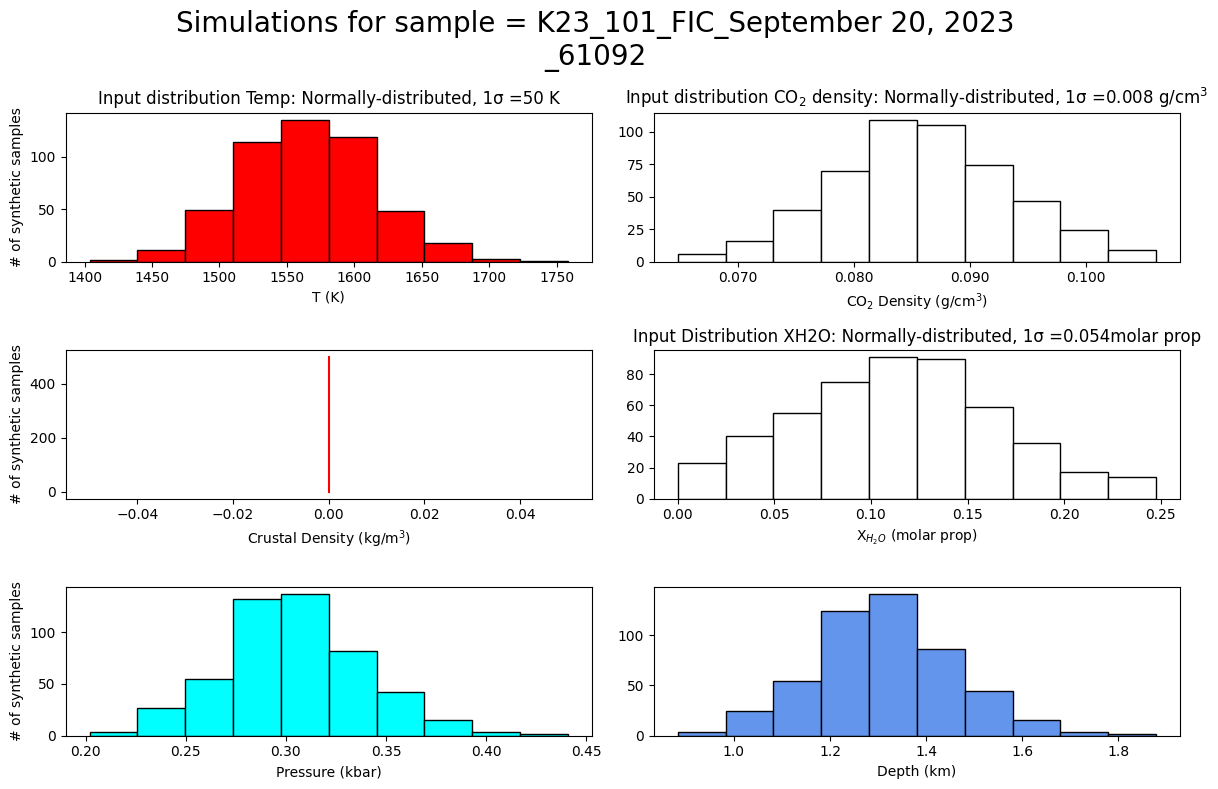

In [17]:
# ## Before doing this, to ensure proper merging we have to create a new column in K23
K23['MCSim_filename(_date_secsincemidnight)']=K23['FI Name']+"_"+K23['date'].astype('str')+"_"+K23['sec since midnight'].astype('str').str.split('.').str[0]

# ## We also create a new column with the CO2 density error, 
# ## if the measurement was averaged, the error is the standard deviation ('Density g/cm3_Raman_STD') 
# ## if it's a single measurement, it's the sigma from DiadFit ('σ Density g/cm3')

K23['error_CO2_dens_STDifmean_σifnot'] = K23['σ Density g/cm3 (as plotted, from DiadFit for individual, Std dev for averaged FI)']

## Now run the simulations
K23_MC_Av_rho_T_df_B, K23_MC_All_rho_T_df_B, K23_fig=pf.propagate_FI_uncertainty(
T_K=K23['Temp_from_Fo_all']+273.15,
error_T_K=K23['Temp_error'], error_type_T_K='Abs', error_dist_T_K='normal',
CO2_dens_gcm3=K23['Density g/cm3'],error_CO2_dens=K23['error_CO2_dens_STDifmean_σifnot'], 
error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
XH2O=K23['XH2O_av_iteration3_final'], error_XH2O=pd.Series(0.5*np.abs(K23['XH2O_max_iteration3_final']-K23['XH2O_min_iteration3_final'])), error_type_XH2O='Abs', error_dist_XH2O='normal',
sample_ID=K23['MCSim_filename(_date_secsincemidnight)'],
model='denlinger_lerner',
N_dup=500, fig_i=0, plot_figure=True)


K23_fig.savefig(figpath+slash+'MCsimulation_K23.pdf')
K23_MC_Av_rho_T_df_B

#### Next, Let's do LERZ2018

You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 200 regardless of what model you selected. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
We are using multiprocessing based on your selected EOS. You can override this by setting multiprocess=False in the function, but it might slow it down a lot
Number of processors:  8


,Filename,i,CO2_density_input,SingleCalc_D_km,SingleCalc_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,"LL4-14dp-FI#1_October 20, 2022\n_46611",0.0,0.176605,2.577375,0.615465,0.618685,0.616575,0.028431,0.027509,2.589727,...,1532.873187,50.0,0.176605,0.001314,None,0.0,denlinger_lerner,DZ06,0.055466,0.029614
1,"LL4-14dp-FI#2_October 20, 2022\n_51301",1.0,0.180578,2.635003,0.630145,0.633643,0.631467,0.030796,0.029655,2.648360,...,1531.215163,50.0,0.180578,0.002910,None,0.0,denlinger_lerner,DZ06,0.054643,0.029323
2,"LL4-14dp-MI#1_October 20, 2022\n_48734",2.0,0.180858,2.644538,0.632577,0.636254,0.633922,0.032788,0.031966,2.658544,...,1534.365617,50.0,0.180858,0.004029,None,0.0,denlinger_lerner,DZ06,0.054514,0.029278
3,"LL4-21-#2_October 18, 2022\n_57539",3.0,0.147317,2.082096,0.490991,0.494057,0.491641,0.025091,0.023519,2.094190,...,1486.618027,50.0,0.147317,0.001696,None,0.0,denlinger_lerner,DZ06,0.066753,0.034190
4,"LL4-21-MI#5_October 21, 2022\n_47328",4.0,0.080378,1.203838,0.277623,0.281287,0.279754,0.022966,0.021464,1.219015,...,1534.208075,50.0,0.080378,0.002942,None,0.0,denlinger_lerner,DZ06,0.116065,0.057431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,"LL8_406-FI#4_April 6, 2023\n_49924",97.0,0.117806,1.721747,0.402316,0.402579,0.394525,0.072328,0.073160,1.720654,...,1531.924023,50.0,0.117806,0.018077,None,0.0,denlinger_lerner,DZ06,0.081526,0.040852
98,"LL8_406_FI#1 _November 29, 2022\n_50339",98.0,0.109444,1.604906,0.373903,0.375419,0.372271,0.031660,0.030470,1.610735,...,1531.924023,50.0,0.109444,0.005739,None,0.0,denlinger_lerner,DZ06,0.087831,0.043797
99,"LL8_406_FI#2_November 29, 2022\n_50318",99.0,0.134293,1.954717,0.459464,0.461625,0.459931,0.024843,0.024466,1.963222,...,1531.924023,50.0,0.134293,0.001189,None,0.0,denlinger_lerner,DZ06,0.071222,0.036156
100,"LL8_406_FI#3_November 29, 2022\n_51263",100.0,0.121505,1.773676,0.414997,0.416994,0.415550,0.024963,0.023478,1.781581,...,1531.924023,50.0,0.121505,0.002200,None,0.0,denlinger_lerner,DZ06,0.078976,0.039674


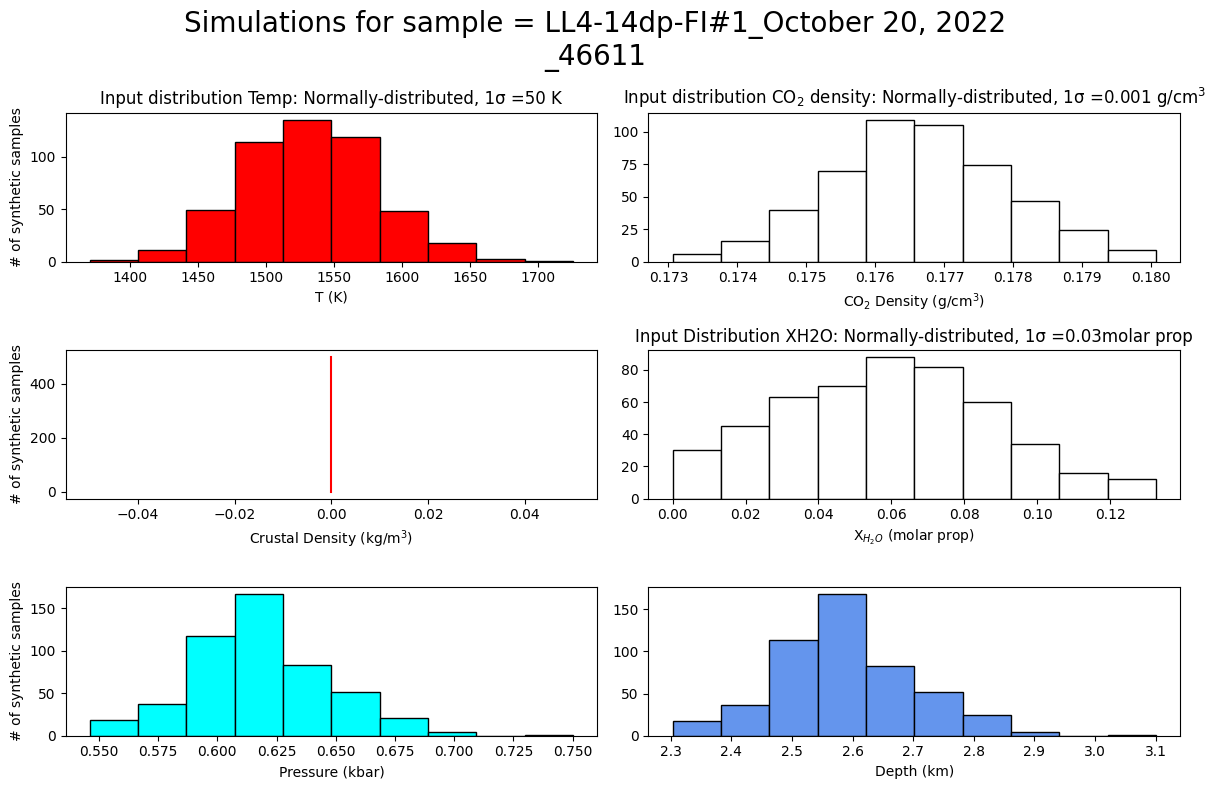

In [18]:
# ## Before doing this, to ensure proper merging we have to create a new column in LERZ2018
LERZ2018['MCSim_filename(_date_secsincemidnight)']=LERZ2018['Fluid inclusion ID']+"_"+LERZ2018['date'].astype('str')+"_"+LERZ2018['sec since midnight'].astype('str').str.split('.').str[0]

# ## We also create a new column with the CO2 density error, 
# ## if the measurement was averaged, the error is the standard deviation ('Density g/cm3_Raman_STD') 
# ## if it's a single measurement, it's the sigma from DiadFit ('CO2 density 1σ (g/cm3)')

LERZ2018['error_CO2_dens_STDifmean_σifnot'] = LERZ2018.apply(
    lambda row: row[ 'CO2 density standard deviation of repeats (g/cm3)'] if row['Mean of repeated Analyses (Yes/No)'] == 'Yes' else row['CO2 density 1σ (g/cm3)'],
    axis=1
)

## Now run the simulations
LERZ2018_MC_Av_rho_T_df_B, LERZ2018_MC_All_rho_T_df_B, LERZ2018_fig=pf.propagate_FI_uncertainty(
T_K=LERZ2018['Temp_from_Fo_all']+273.15,
error_T_K=LERZ2018['Temp_error'], error_type_T_K='Abs', error_dist_T_K='normal',
CO2_dens_gcm3=LERZ2018['CO2 density (g/cm3)'],error_CO2_dens=LERZ2018['error_CO2_dens_STDifmean_σifnot'], 
error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
XH2O=LERZ2018['XH2O_av_iteration3_final'], error_XH2O=pd.Series(0.5*np.abs(LERZ2018['XH2O_max_iteration3_final']-LERZ2018['XH2O_min_iteration3_final'])), error_type_XH2O='Abs', error_dist_XH2O='normal',
sample_ID=LERZ2018['MCSim_filename(_date_secsincemidnight)'],
model='denlinger_lerner',
N_dup=500, fig_i=0, plot_figure=True)


LERZ2018_fig.savefig(figpath+slash+'MCsimulation_LERZ2018.pdf')
LERZ2018_MC_Av_rho_T_df_B

### B. Merge results back into the main dataframe

#### First K23

In [19]:
# First, we rename the Filename column from the simulations, to merge 
K23_MC_Av_rho_T_df_B=K23_MC_Av_rho_T_df_B.rename(columns={'Filename':'MCSim_filename(_date_secsincemidnight)'})

# Then we merge back in using the special filename column
K23_wcalcs = pd.merge(K23,K23_MC_Av_rho_T_df_B, how='outer', on='MCSim_filename(_date_secsincemidnight)', suffixes=[None, 'MCSim'])
K23_wcalcs
# to make sure of duplicate columns can use this code: K23_wcalcs[K23_wcalcs.columns[K23_wcalcs.columns.str.contains('filename')]]

,Column headers,py_index,Crystal Name,FI Name,Reported density mean of reps?,Density g/cm3,"σ Density g/cm3 (as plotted, from DiadFit for individual, Std dev for averaged FI)",STDofreps_Density g/cm3,σ Density g/cm3 (DiadFit),σ Density g/cm3 (from Ne+peakfit),...,T_K_input,error_T_KMCSim,CO2_dens_gcm3_input,error_CO2_dens_gcm3MCSim,crust_dens_kgm3_input,error_crust_dens_kgm3MCSim,model,EOSMCSim,XH2O_input,error_XH2O
0,NaN,0,K23_101,K23_101_FIC,No,0.085665,0.007736,NaN,0.007736,0.006738,...,1565.805593,50.0,0.085665,0.007736,None,0.0,denlinger_lerner,DZ06,0.108233,0.053578
1,NaN,1,K23_101,K23_101_FID,No,0.100137,0.005037,NaN,0.005037,0.003301,...,1565.805593,50.0,0.100137,0.005037,None,0.0,denlinger_lerner,DZ06,0.093852,0.046643
2,NaN,2,K23_102,K23_102_FIA,No,0.112454,0.004482,NaN,0.004482,0.002350,...,1564.096549,50.0,0.112454,0.004482,None,0.0,denlinger_lerner,DZ06,0.083756,0.041885
3,NaN,15,KS23_103,K23_103_FIC,No,0.114374,0.004013,NaN,0.004013,0.001231,...,1511.482018,50.0,0.114374,0.004013,None,0.0,denlinger_lerner,DZ06,0.085135,0.042535
4,NaN,16,KS23_103,K23_103_FID,Yes,0.126346,0.001619,0.001619,0.004087,0.001400,...,1511.482018,50.0,0.126346,0.001619,None,0.0,denlinger_lerner,DZ06,0.076872,0.038712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,NaN,11,K23_7,K23_7_FIA,No,0.118112,0.003895,NaN,0.003895,0.000734,...,1457.137953,50.0,0.118112,0.003895,None,0.0,denlinger_lerner,DZ06,0.085425,0.042681
58,NaN,12,K23_7,K23_7_FIB,No,0.115662,0.004004,NaN,0.004004,0.001198,...,1457.137953,50.0,0.115662,0.004004,None,0.0,denlinger_lerner,DZ06,0.087248,0.043536
59,NaN,13,K23_7,K23_7_FIC,No,0.112891,0.004063,NaN,0.004063,0.001390,...,1457.137953,50.0,0.112891,0.004063,None,0.0,denlinger_lerner,DZ06,0.089382,0.044542
60,NaN,14,K23_9,K23_9_FIA,No,0.083276,0.004746,NaN,0.004746,0.002841,...,1504.386368,50.0,0.083276,0.004746,None,0.0,denlinger_lerner,DZ06,0.114549,0.056688


#### Next, LERZ2018

In [20]:
# First, we rename the Filename column from the simulations, to merge 
LERZ2018_MC_Av_rho_T_df_B=LERZ2018_MC_Av_rho_T_df_B.rename(columns={'Filename':'MCSim_filename(_date_secsincemidnight)'})

# Then we merge back in using the special filename column
LERZ2018_wcalcs = pd.merge(LERZ2018,LERZ2018_MC_Av_rho_T_df_B, how='outer', on='MCSim_filename(_date_secsincemidnight)', suffixes=[None, 'MCSim'])
LERZ2018_wcalcs
# to make sure of duplicate columns can use this code: LERZ2018_wcalcs[LERZ2018_wcalcs.columns[LERZ2018_wcalcs.columns.str.contains('filename')]]

,Py_index,Event Description,"Event ID (LL8 - July, LL7-Aug, LL4-May)",Host crystal ID,Fluid inclusion ID,Raman Data >,Fermi Diad separation ΔCO2 (cm-1),Corrected ΔCO2 (cm-1),Corrected ΔCO2 1σ (cm-1),CO2 density (g/cm3),...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,0,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#1,ν1 refers to the low wavenumber band of the fe...,103.416763,103.186144,0.006461,0.176605,...,1532.873187,50.0,0.176605,0.001314,None,0.0,denlinger_lerner,DZ06,0.055466,0.029614
1,1,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-FI#2,NaN,103.431244,103.195894,0.007137,0.180578,...,1531.215163,50.0,0.180578,0.002910,None,0.0,denlinger_lerner,DZ06,0.054643,0.029323
2,2,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-14dp,LL4-14dp-MI#1,NaN,103.429713,103.196578,0.010404,0.180858,...,1534.365617,50.0,0.180858,0.004029,None,0.0,denlinger_lerner,DZ06,0.054514,0.029278
3,3,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-#2,NaN,103.379425,103.122405,0.001766,0.147317,...,1486.618027,50.0,0.147317,0.001696,None,0.0,denlinger_lerner,DZ06,0.066753,0.034190
4,7,"LERZ, Fissure 8, May 30th 2018",LL4,LL4-21,LL4-21-MI#5,NaN,103.170121,102.953345,0.007431,0.080378,...,1534.208075,50.0,0.080378,0.002942,None,0.0,denlinger_lerner,DZ06,0.116065,0.057431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,139,"LERZ, Fissure 8, Mid July 2018",LL8,LL8_406,LL8_406-FI#4,NaN,103.299352,103.047874,0.045655,0.117806,...,1531.924023,50.0,0.117806,0.018077,None,0.0,denlinger_lerner,DZ06,0.081526,0.040852
98,140,"LERZ, Fissure 8, Mid July 2018",LL8,LL8_406,LL8_406_FI#1,NaN,103.269854,103.026754,0.006926,0.109444,...,1531.924023,50.0,0.109444,0.005739,None,0.0,denlinger_lerner,DZ06,0.087831,0.043797
99,141,"LERZ, Fissure 8, Mid July 2018",LL8,LL8_406,LL8_406_FI#2,NaN,103.332884,103.089512,0.003002,0.134293,...,1531.924023,50.0,0.134293,0.001189,None,0.0,denlinger_lerner,DZ06,0.071222,0.036156
100,142,"LERZ, Fissure 8, Mid July 2018",LL8,LL8_406,LL8_406_FI#3,NaN,103.300169,103.057215,0.005555,0.121505,...,1531.924023,50.0,0.121505,0.002200,None,0.0,denlinger_lerner,DZ06,0.078976,0.039674


## 7. Final data export for plotting

In [21]:
LERZ2018_wcalcs.to_excel(compilation_folder+slash+'LERZ2018_recalculated.xlsx')
K23_wcalcs.to_excel(compilation_folder+slash+'K23_recalculated.xlsx')